# Práctica 4a: selección de características numéricas

## Recipe

**Nota:** antes de implementar los siguientes métodos, debemos asegurarnos de que el `DataFrame` sólo contiene características numéricas.

In [2]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [22]:
# Cargamos el dataset
file = "../../conjunto_de_datos_visita_museos_2018.csv"
df = pd.read_csv(file)
df = df.drop('COND_ESCOL', 1)
df = df.drop('LENGUA_2', 1)
df = df.drop('LENGUA_3', 1)
df = df.drop('VISIT_ANIO', 1)
df = df.drop('ANIOS_VISI', 1)
df = df.drop('VISO_CUANT', 1)
df = df.drop('MEDIO_2', 1)
df = df.drop('TAM_GRUPO', 1)
df = df.drop('NIV_APREND', 1)
df = df.drop('M_NOVIS_2', 1)
df = df.drop('M_NOVIS_3', 1)
X = df.drop("SEXO",1)   #Características
y = df["SEXO"]          #Target
df.head()
df

,ANIO_ESTAD,ENT_REGIS,MES_ENTREV,DIA_ENTREV,SEXO,EDAD,ENT_RESID,MUN_RESID,PAIS_RESID,NACIONALID,...,SU_ARCHIVO,SU_SILLA,SU_OTRO,OPIN_EXPOS,DUR_VIS_H,DUR_VIS_M,REPETIR_VI,RECOMIE_VI,EVAL_GRAL,M_NOVIS_1
0,2018,1,7,1,2,23,1,1,0,1,...,0,0,0,2,0,30,1,12,9,1
1,2018,1,7,1,2,36,1,1,0,1,...,0,0,0,1,0,15,1,14,10,1
2,2018,1,7,1,2,23,1,1,0,1,...,0,0,0,2,0,25,1,12,10,5
3,2018,1,7,1,2,35,1,1,0,1,...,0,0,0,2,0,15,1,12,10,8
4,2018,1,7,2,2,22,15,106,0,1,...,0,0,0,1,0,40,1,15,9,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182764,2018,32,10,1,1,62,8,37,0,1,...,0,0,0,1,1,30,1,13,9,9
182765,2018,32,10,1,2,20,32,56,0,1,...,0,0,0,1,1,0,1,13,9,9
182766,2018,32,10,1,1,18,32,10,0,1,...,0,0,0,2,1,10,1,14,10,6
182767,2018,32,10,1,2,48,9,3,0,1,...,0,0,0,2,1,0,1,12,9,8


### Filter Method

Como su nombre indica, en este método se filtra y se toma sólo el subconjunto de las características relevantes. El modelo se construye después de seleccionar las características. El filtrado aquí se hace usando una matriz de correlación.

El método es el siguiente, primero graficaremos el mapa de calor de la correlación Pearson y veremos la correlación de las variables independientes o características con la variable de salida o target. Sólo seleccionaremos las características que tengan una correlación superior a 0.5 (tomando valor absoluto) con la variable de salida.

Recordando que el coeficiente de correlación de Pearson tiene valores entre -1 y 1:
- Un valor más cercano a 0 
    * implica una correlación más débil (un 0 exacto implica que no hay correlación)
- Un valor más cercano a 1 
    * implica una correlación positiva más fuerte
- Un valor más cercano a -1 
    * implica una correlación negativa más fuerte

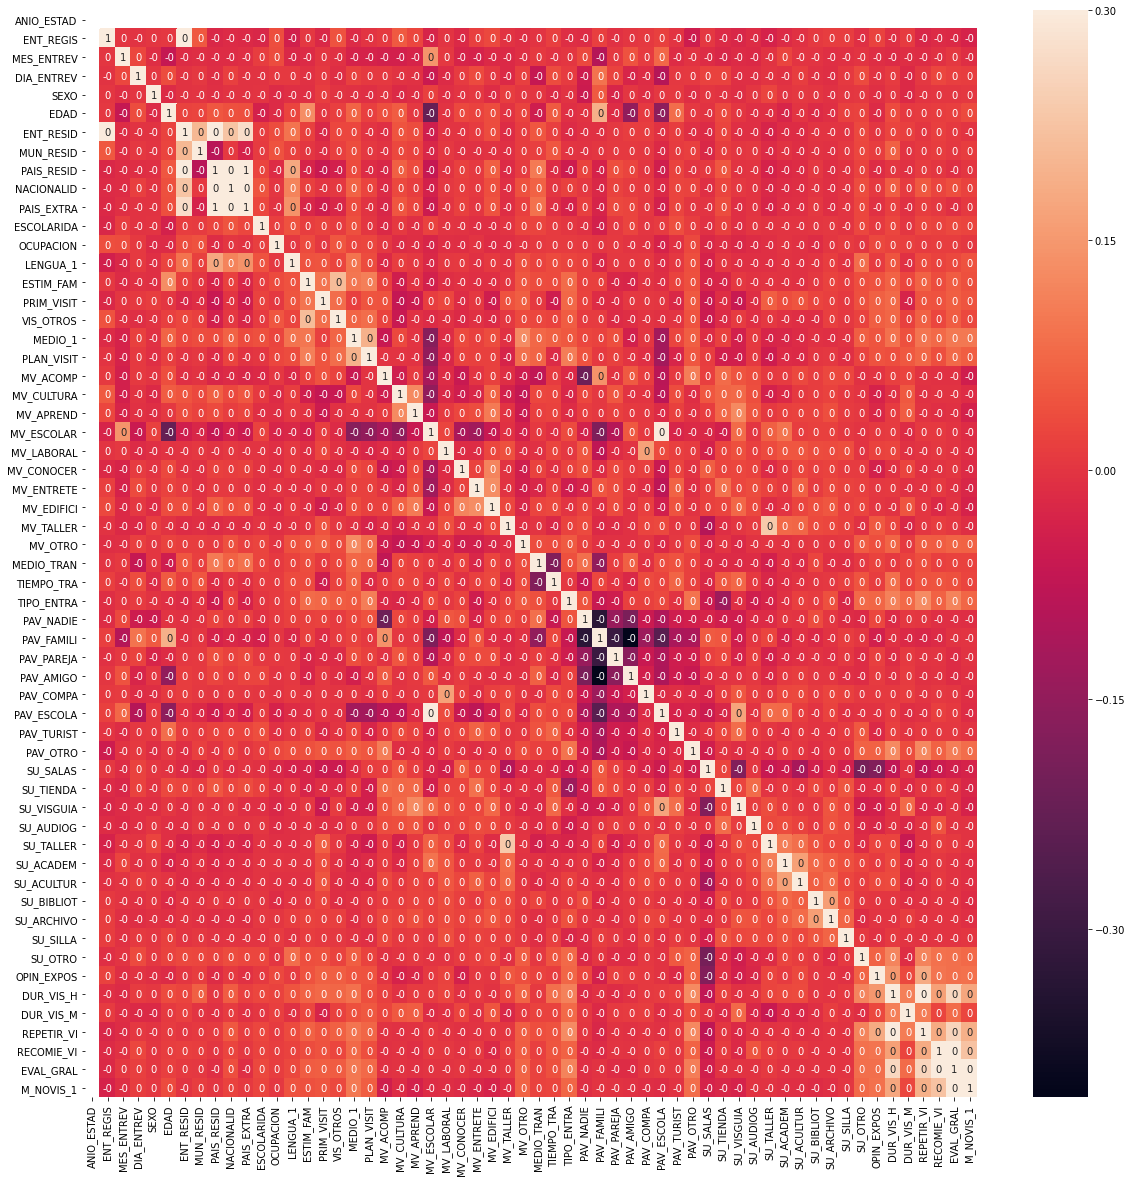

In [51]:
plt.figure(figsize=(20,20))
cor = df.corr()
#sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, fmt="d")
sns.heatmap(cor, vmax=.3, annot = True, fmt = ".0f")
plt.show()

In [30]:
#Correlación respecto a la variable de salida o target
cor_target = abs(cor["SEXO"])

#Selección de características altamente correlacionadas
relevant_features = cor_target[cor_target>0.05]
relevant_features

SEXO          1.000000
PAV_NADIE     0.053499
PAV_FAMILI    0.055113
Name: SEXO, dtype: float64

Como podemos ver, sólo las características `PAV_NADIE` Y `PAV_FAMILI` están  correlacionadas con la variable target `SEXO`. Por lo tanto, ignoraremos las demás características. Sin embargo, este no es el final del proceso. Una de las suposiciones de la regresión lineal es que las variables independientes necesitan ser descorrelacionadas entre sí. Es decir, si estas variables están correlacionadas entre sí, entonces necesitamos mantener sólo una de ellas y eliminar el resto. Así que vamos a comprobar la correlación de las características seleccionadas entre sí. Esto se puede hacer ya sea comprobando visualmente desde la matriz de correlación de arriba o desde el fragmento de código de abajo.

In [52]:
print(df[["SEXO","PAV_NADIE"]].corr())
print(df[["SEXO","PAV_FAMILI"]].corr())
print(df[["PAV_NADIE","PAV_FAMILI"]].corr())

               SEXO  PAV_NADIE
SEXO       1.000000  -0.053499
PAV_NADIE -0.053499   1.000000
                SEXO  PAV_FAMILI
SEXO        1.000000    0.055113
PAV_FAMILI  0.055113    1.000000
            PAV_NADIE  PAV_FAMILI
PAV_NADIE    1.000000   -0.328744
PAV_FAMILI  -0.328744    1.000000


Del código anterior, se ve que las variables `PAV_NADIE` y `PAV_FAMILI` están altamente correlacionadas entre sí (-0.328744, y en valor absoluto supera el umbral que definimos). Por lo tanto, mantendríamos sólo una variable y dejaríamos la otra. Mantendremos `PAV_FAMILI` ya que su correlación con `SEXO` es mayor que la de PAV_NADIE.
Después de dejar `PAV_NADIE`, nos quedan dos características,`PAV_FAMILI` y `SEXO`. Estas son las últimas características dadas por la correlación de Pearson.

### Wrapper Method

El "método de envoltura" necesita un algoritmo de aprendizaje automático y utiliza su rendimiento como criterio de evaluación. Esto significa que se alimentan las funciones al algoritmo de aprendizaje automático seleccionado y, en función del rendimiento del modelo, se añaden o eliminan funciones. Se trata de un proceso iterativo y costoso desde el punto de vista computacional, pero es más preciso que el método de filtrado.
Existen diferentes métodos de envoltura como la eliminación hacia atrás (Backward Elimination), la selección hacia adelante (Forward Selection), la eliminación bidireccional (Bidirectional Elimination) y la eliminación recursiva de características RFE. Discutiremos la eliminación hacia atrás y RFE aquí.

#### Backward Elimination

Al principio alimentamos el modelo con todas las características posibles, comprobamos el rendimiento del modelo y luego eliminamos las características de peor rendimiento una por una hasta que el rendimiento total del modelo se encuentre en un rango aceptable.
La métrica de rendimiento utilizada aquí para evaluar el rendimiento de las características es `pvalue`. Si el valor `p` **es superior** a `0.05`, entonces eliminamos la característica, de otro modo la mantenemos.
Primero ejecutaremos una iteración aquí sólo para tener una idea del concepto y luego ejecutaremos el mismo código en un bucle, lo que dará el conjunto final de características. Aquí estamos usando el modelo `OLS` que significa "Ordinary Least Squares". Este modelo se utiliza para realizar una regresión lineal.

In [31]:
#Agregar una columna constante de unos, obligatorio para el modelo sm.OLS
X_1 = sm.add_constant(X)

#Ajuste del modelo sm.OLS
model = sm.OLS(y,X_1).fit()
model.pvalues.sort_values(ascending=False)

C:\tools\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


NACIONALID    9.991586e-01
ENT_RESID     9.808875e-01
SU_SALAS      7.976498e-01
MUN_RESID     7.955982e-01
MEDIO_1       7.667043e-01
TIPO_ENTRA    7.572196e-01
EVAL_GRAL     6.544043e-01
SU_SILLA      6.129063e-01
MV_OTRO       6.010570e-01
PAV_AMIGO     5.571596e-01
ESCOLARIDA    5.546143e-01
RECOMIE_VI    5.190701e-01
REPETIR_VI    5.165749e-01
VIS_OTROS     4.312494e-01
SU_AUDIOG     4.184322e-01
M_NOVIS_1     4.053826e-01
PAV_ESCOLA    3.472988e-01
SU_OTRO       2.671915e-01
SU_ACULTUR    2.604086e-01
MV_ENTRETE    2.306835e-01
PLAN_VISIT    2.203958e-01
ENT_REGIS     2.199762e-01
DIA_ENTREV    1.961259e-01
MV_CONOCER    1.810414e-01
PAIS_RESID    1.582371e-01
SU_TIENDA     1.327356e-01
PAIS_EXTRA    1.298212e-01
SU_ACADEM     1.253803e-01
SU_BIBLIOT    7.733590e-02
MV_APREND     5.293100e-02
MV_LABORAL    3.558089e-02
DUR_VIS_H     6.074114e-03
PAV_OTRO      2.640099e-03
SU_ARCHIVO    2.612464e-03
ESTIM_FAM     2.050148e-03
PAV_COMPA     1.709511e-03
SU_VISGUIA    1.520718e-03
L

In [43]:
#Backward Elimination
cols = list(X.columns)
pmax = 1

while (len(cols)>0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[0:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(selected_features_BE)

['ANIO_ESTAD', 'MES_ENTREV', 'EDAD', 'OCUPACION', 'LENGUA_1', 'ESTIM_FAM', 'PRIM_VISIT', 'MV_ACOMP', 'MV_CULTURA', 'MV_ESCOLAR', 'MV_LABORAL', 'MV_EDIFICI', 'MV_TALLER', 'MEDIO_TRAN', 'TIEMPO_TRA', 'PAV_NADIE', 'PAV_FAMILI', 'PAV_PAREJA', 'PAV_COMPA', 'PAV_TURIST', 'PAV_OTRO', 'SU_VISGUIA', 'SU_TALLER', 'SU_ARCHIVO', 'OPIN_EXPOS', 'DUR_VIS_H', 'DUR_VIS_M']


#### Recursive Feature Elimination (RFE)

El método recursivo de eliminación de características (RFE) funciona mediante la eliminación recursiva de atributos y la construcción de un modelo sobre los atributos que quedan. Utiliza una métrica de precisión para clasificar la característica según su importancia. El método RFE toma como entrada el modelo a ser utilizado y el número de características requeridas. A continuación, proporciona la clasificación de todas las variables, siendo `1` la más importante y en descendencia las menos importantes; viéndolo de forma más concisa, `True` la característica relevante y `False` la característica irrelevante.

In [44]:
model = LinearRegression()

#Método RFE
rfe = RFE(model, 7, verbose=1)

#Transformando los datos usando el método RFE
X_rfe = rfe.fit_transform(X,y)  

#Encontrando el modelo de los datos
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 fe

Aquí tomamos el modelo `LinearRegression` con 7 características y RFE dio la clasificación de características como arriba, pero la selección del número '7' fue aleatoria, pudimos haber puesto '3' u '11'. Ahora necesitamos encontrar este número óptimo de características, para las cuales la precisión es la más alta. Esto lo hacemos usando el bucle que empieza con 1 característica y sube hasta 13. Luego tomamos la característica para la cual la precisión es más alta.

In [45]:
#Número de características
nof_list = np.arange(1,13)            
high_score = 0

#Proceso para almacenar las características óptimas
nof = 0           
score_list = []

for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Número óptimo de características: %d" %nof)
print("Desempeño con %d características: %f" % (nof, high_score))

Número óptimo de características: 12
Desempeño con 12 características: 0.005635


Como se ve en el código anterior, el número óptimo de características es 10. Ahora alimentamos 10 como número de características a RFE y obtenemos el conjunto final de características dadas por el método RFE.

In [46]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 12)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index=cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['MV_ACOMP', 'MV_ESCOLAR', 'MV_LABORAL', 'MV_TALLER', 'PAV_NADIE',
       'PAV_FAMILI', 'PAV_PAREJA', 'PAV_COMPA', 'PAV_TURIST', 'PAV_OTRO',
       'SU_TALLER', 'SU_ARCHIVO'],
      dtype='object')


### Embedded Method

Los métodos integrados se ocupa de cada iteración del proceso de entrenamiento del modelo y extrae cuidadosamente las características que más contribuyen al entrenamiento para una iteración en particular. Los métodos de **regularización** son los métodos integrados más utilizados, ya que penalizan una característica dado un umbral. Entonces haremos la selección de características mediante un método integrado, usando la regularización de Lasso:
> "Si la característica es irrelevante, Lasso penaliza su peso y lo convierte en 0. Por lo tanto, las características con peso = 0 se eliminan y el resto se toman."

In [47]:
reg = LassoCV()
reg.fit(X, y)
coef = pd.Series(reg.coef_, index = X.columns)
print("Número óptimo de características:" + str(sum(coef != 0)))
print("Desempeño mediante la regularización Lasso: %f" %reg.score(X,y))

C:\tools\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Número óptimo de características:46
Desempeño mediante la regularización Lasso: 0.008809


Text(0.5, 1.0, 'Importancia de las características usando el modelo de Lasso')

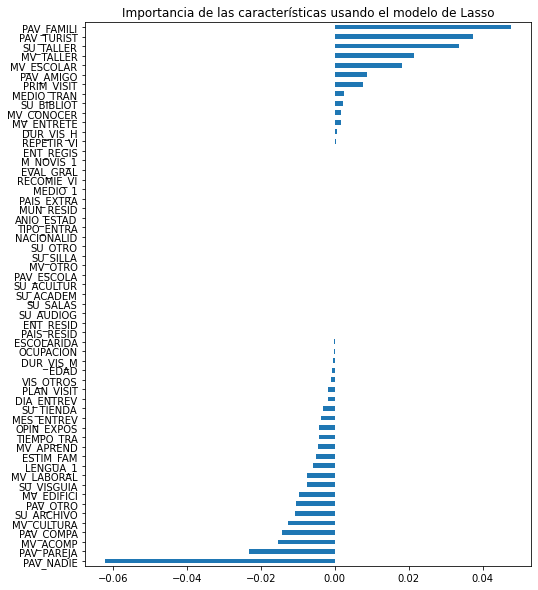

In [50]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Importancia de las características usando el modelo de Lasso")